In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

x,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [3]:
len(x),len(y)

(1000, 1000)

In [4]:
x[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [5]:
y[:5]

array([1, 1, 1, 1, 0])

In [6]:
import pandas as pd
circles = pd.DataFrame({'x1':x[:,0],'x2':x[:,1],'label':y})
circles.head(5)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


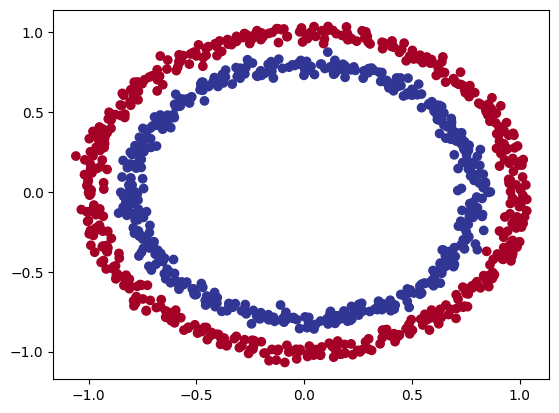

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap = plt.cm.RdYlBu
            );

In [8]:
x.shape,y.shape

((1000, 2), (1000,))

In [9]:
import torch
torch.__version__

'2.9.0+cu126'

In [10]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
type(x),x.dtype

(torch.Tensor, torch.float32)

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

In [13]:
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
from torch import nn

In [16]:
x_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [17]:
from sklearn import datasets

In [18]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self,x):
    return self.layer_2(self.layer_1(x))

In [19]:
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5945, -0.2328],
                      [ 0.1590,  0.3974],
                      [-0.2475, -0.0979],
                      [ 0.5718,  0.2763],
                      [-0.3818,  0.5425]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0539, -0.2373, -0.1746, -0.5679,  0.1358], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1751, -0.1693, -0.1951,  0.2109, -0.2214]], device='cuda:0')),
             ('1.bias', tensor([0.1343], device='cuda:0'))])

In [22]:
with torch.inference_mode():
  untrained_preds = model_0(x_test.to(device))
print(f"length of preds: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"lenght of test samples: {len(y_test)}, shape: {y_test.shape}")
print(f"\nFirst 10 preds: {untrained_preds[:10]}")
print(f"\nFirst 10 labels: {y_test[:10]}")

length of preds: 200, shape: torch.Size([200, 1])
lenght of test samples: 200, shape: torch.Size([200])

First 10 preds: tensor([[-0.0251],
        [ 0.0035],
        [ 0.0039],
        [-0.0337],
        [ 0.1689],
        [ 0.1851],
        [ 0.1348],
        [ 0.1778],
        [-0.0031],
        [ 0.0073]], device='cuda:0')

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [24]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [25]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_test.to(device))[:5]
y_logits

tensor([[-0.0251],
        [ 0.0035],
        [ 0.0039],
        [-0.0337],
        [ 0.1689]], device='cuda:0')

In [27]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4937],
        [0.5009],
        [0.5010],
        [0.4916],
        [0.5421]], device='cuda:0')

In [28]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 1., 0., 1.], device='cuda:0')

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

x_train,y_train = x_train.to(device),y_train.to(device)
x_test,y_test = x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69486, Acc: 51.50% | Test loss: 0.69438, Test acc: 53.50
Epoch: 10 | Loss: 0.69433, Acc: 50.50% | Test loss: 0.69418, Test acc: 56.00
Epoch: 20 | Loss: 0.69400, Acc: 50.25% | Test loss: 0.69409, Test acc: 54.00
Epoch: 30 | Loss: 0.69377, Acc: 50.38% | Test loss: 0.69405, Test acc: 53.00
Epoch: 40 | Loss: 0.69361, Acc: 50.12% | Test loss: 0.69404, Test acc: 52.50
Epoch: 50 | Loss: 0.69349, Acc: 49.88% | Test loss: 0.69403, Test acc: 52.00
Epoch: 60 | Loss: 0.69339, Acc: 50.12% | Test loss: 0.69404, Test acc: 51.50
Epoch: 70 | Loss: 0.69331, Acc: 50.12% | Test loss: 0.69405, Test acc: 51.50
Epoch: 80 | Loss: 0.69325, Acc: 50.62% | Test loss: 0.69407, Test acc: 51.00
Epoch: 90 | Loss: 0.69320, Acc: 50.38% | Test loss: 0.69408, Test acc: 49.50


In [30]:
from helper_functions import plot_predictions,plot_decision_boundary

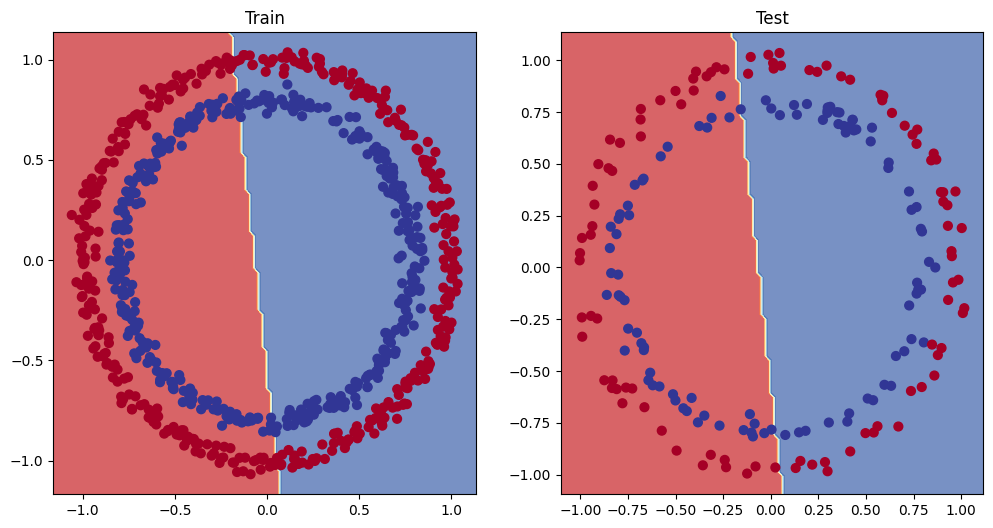

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,x_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,x_test,y_test)

In [32]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6085, -0.2492],
                      [ 0.1694,  0.3852],
                      [-0.2348, -0.1129],
                      [ 0.5566,  0.2942],
                      [-0.3686,  0.5271]])),
             ('0.bias', tensor([-0.0443, -0.2296, -0.1653, -0.5787,  0.1458])),
             ('1.weight',
              tensor([[-0.2334, -0.1376, -0.1787,  0.2234, -0.1595]])),
             ('1.bias', tensor([0.0850]))])

In [33]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)

    return self.layer_3(self.layer_2(self.layer_1(x)))


In [34]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train,y_train = x_train.to(device),y_train.to(device)
x_test,y_test = x_test.to(device),y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  y_logits = model_1(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


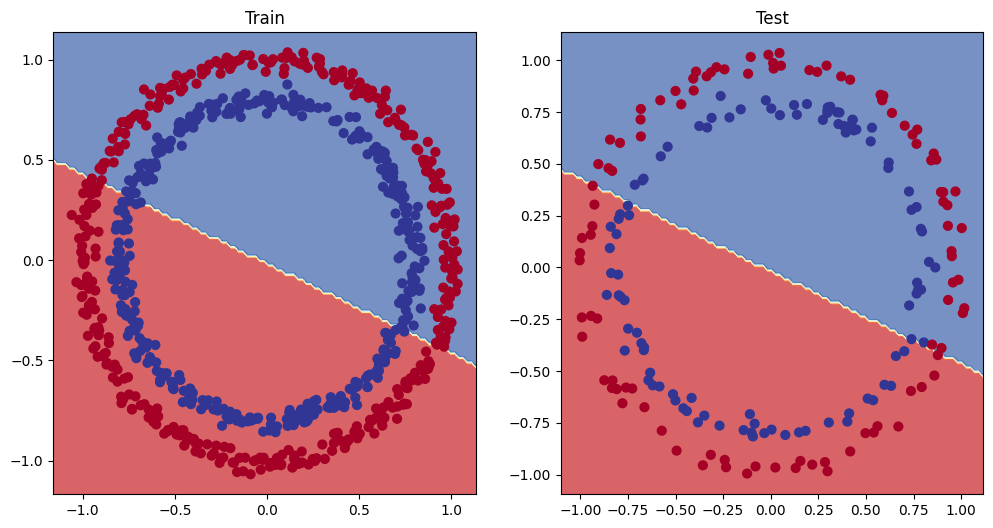

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,x_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,x_test,y_test)

In [38]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

x_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * x_regression + bias

print(len(x_regression))
x_regression[:5],y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
trian_split = int(0.8*len(x_regression))
x_train_regression,y_train_regression = x_regression[:trian_split],y_regression[:trian_split]
x_test_regression,y_test_regression = x_regression[trian_split:],y_regression[trian_split:]

len(x_train_regression),len(x_test_regression),len(y_train_regression),len(y_test_regression)

(80, 20, 80, 20)

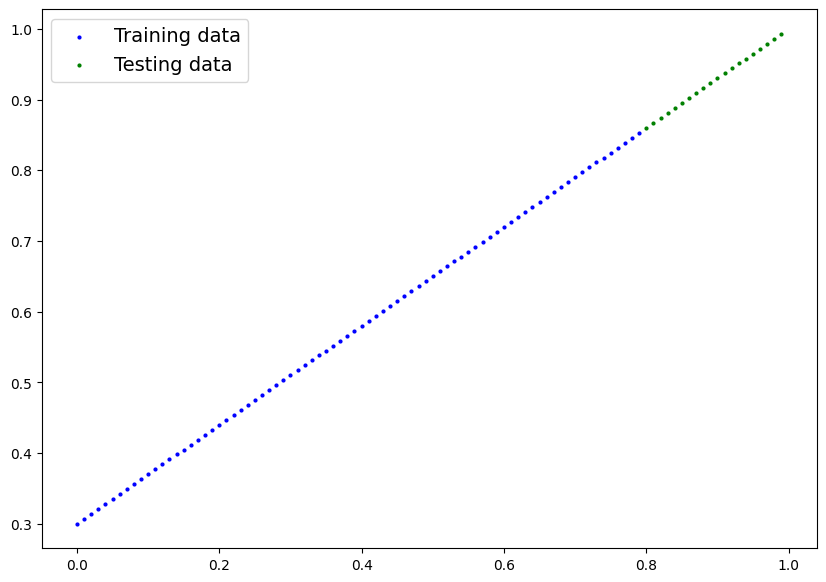

In [40]:
plot_predictions(train_data=x_train_regression,
                 train_labels=y_train_regression,
                 test_data=x_test_regression,
                 test_labels=y_test_regression)

In [41]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train_regression,y_train_regression = x_train_regression.to(device),y_train_regression.to(device)
x_test_regression,y_test_regression = x_test_regression.to(device),y_test_regression.to(device)

for epoch in range(epochs):

  model_2.train()
  y_pred = model_2(x_train_regression)

  loss = loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(x_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


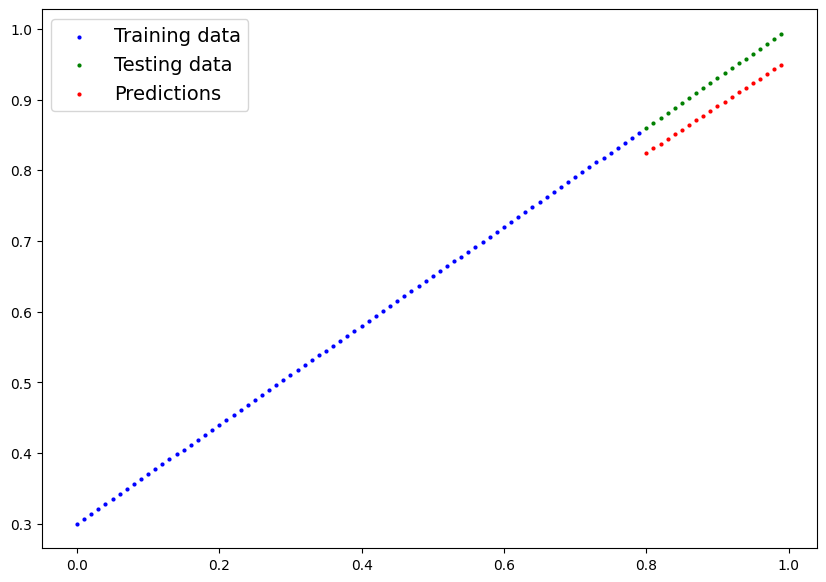

In [44]:
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(x_test_regression)

plot_predictions(train_data=x_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=x_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

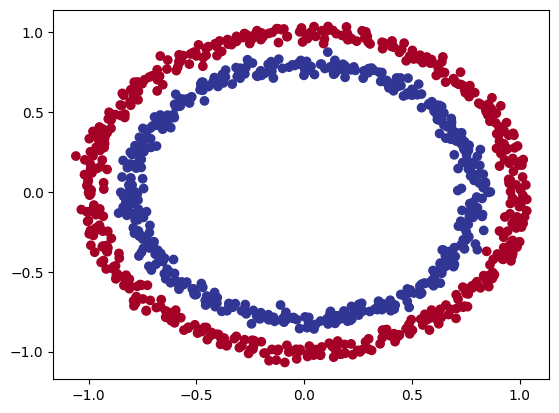

In [45]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000
x,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.RdYlBu)

In [46]:
import torch
from sklearn.model_selection import train_test_split

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [47]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [48]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train,y_train = x_train.to(device),y_train.to(device)
x_test,y_test = x_test.to(device),y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test loss: 0.6932, Test acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test loss: 0.6910, Test acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test loss: 0.6894, Test acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test loss: 0.6872, Test acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test loss: 0.6841, Test acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test loss: 0.6794, Test acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test loss: 0.6729, Test acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test loss: 0.6632, Test acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test loss: 0.6476, Test acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test loss: 0.6215, Test acc: 79.00%


In [51]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(x_test))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

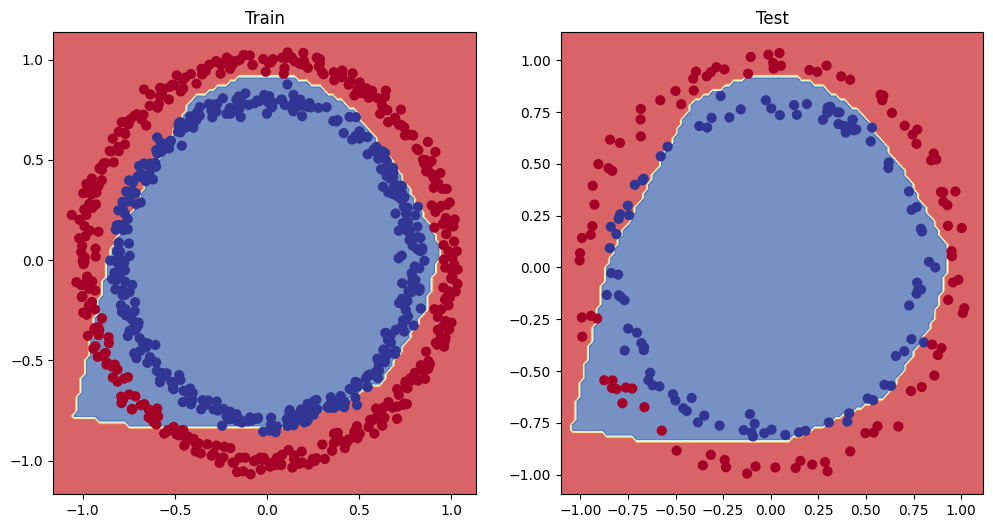

In [52]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3,x_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3,x_test,y_test)

In [53]:
A = torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

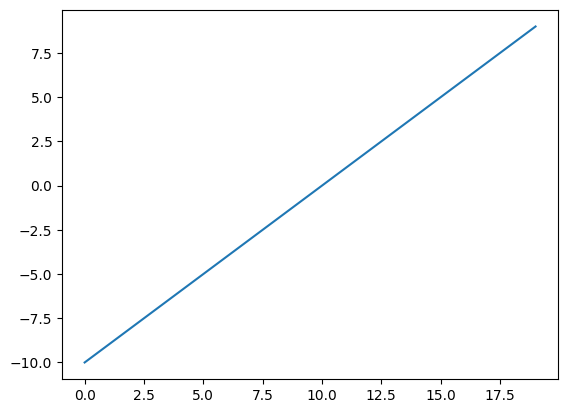

In [54]:
plt.plot(A)

In [55]:
def relu(x:torch.Tensor)->torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

In [56]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

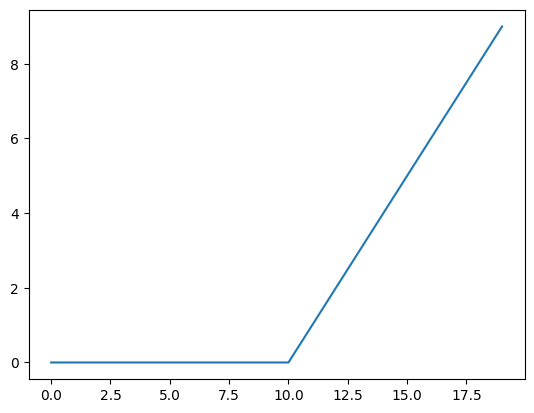

In [57]:
plt.plot(relu(A))

In [58]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

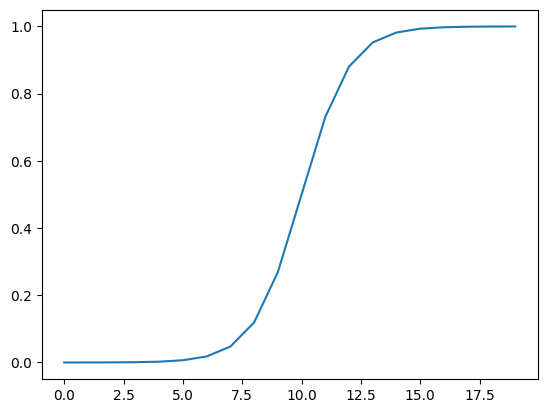

In [59]:
plt.plot(torch.sigmoid(A))

In [60]:
from sklearn.datasets import make_blobs

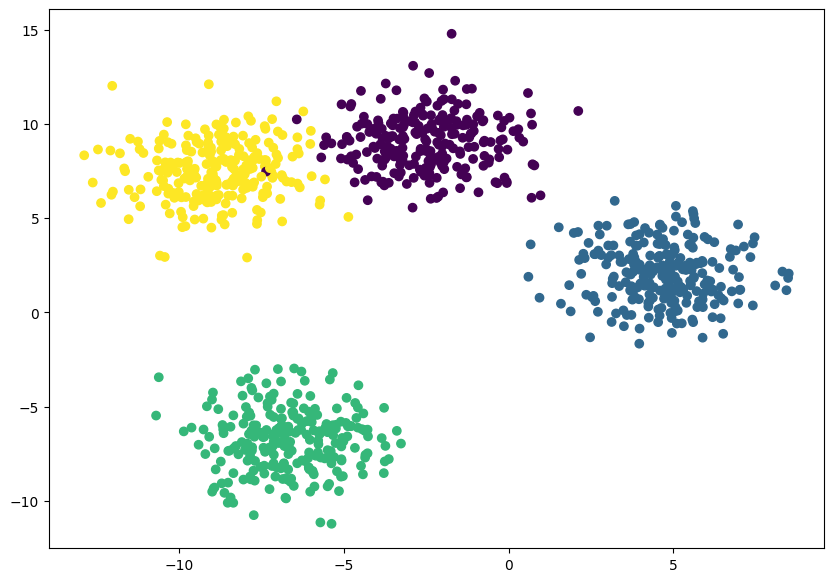

In [74]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

x_blob_train,x_blob_test,y_blob_train,y_blob_test = train_test_split(x_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(x=x_blob[:,0],
            y=x_blob[:,1],
            c=y_blob)


In [88]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.liner_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.liner_layer_stack(x)


model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (liner_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [89]:
x_blob_train.shape,y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [91]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test.to(device))
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [92]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [93]:
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0')
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0')


In [94]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0')

In [95]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [96]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

x_blob_train,y_blob_train = x_blob_train.to(device),y_blob_train.to(device)
x_blob_test,y_blob_test = x_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(x_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(x_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.0432, Acc: 65.50% | Test loss: 0.5786, Test acc: 95.50%
Epoch: 10 | Loss: 0.1440, Acc: 99.12% | Test loss: 0.1304, Test acc: 99.00%
Epoch: 20 | Loss: 0.0806, Acc: 99.12% | Test loss: 0.0722, Test acc: 99.50%
Epoch: 30 | Loss: 0.0592, Acc: 99.12% | Test loss: 0.0513, Test acc: 99.50%
Epoch: 40 | Loss: 0.0489, Acc: 99.00% | Test loss: 0.0410, Test acc: 99.50%
Epoch: 50 | Loss: 0.0429, Acc: 99.00% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 60 | Loss: 0.0391, Acc: 99.00% | Test loss: 0.0308, Test acc: 99.50%
Epoch: 70 | Loss: 0.0364, Acc: 99.00% | Test loss: 0.0280, Test acc: 99.50%
Epoch: 80 | Loss: 0.0345, Acc: 99.00% | Test loss: 0.0259, Test acc: 99.50%
Epoch: 90 | Loss: 0.0330, Acc: 99.12% | Test loss: 0.0242, Test acc: 99.50%


In [97]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [98]:
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3698e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2267e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5436e-08, 4.7620e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4288e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8305e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0768e-09, 2.0006e-04]], device='cuda:0')

In [99]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

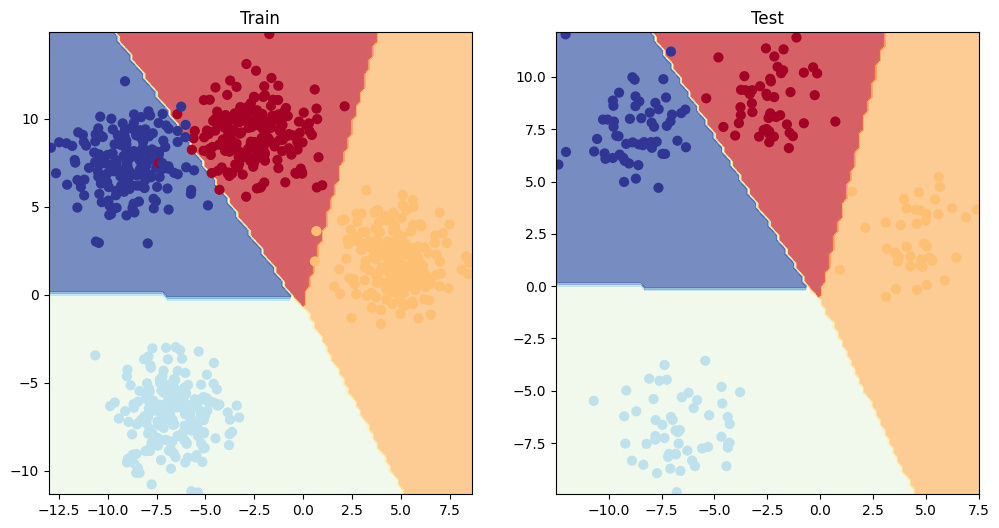

In [100]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4,x_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4,x_blob_test,y_blob_test)

In [102]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.6 MB/s eta 0:00:00


In [103]:
from torchmetrics import Accuracy

In [113]:
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

torchmetrics_accuracy(y_preds,y_blob_test)

tensor(0.6800, device='cuda:0')